In [50]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import warnings
import talib as ta
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def _ensure_datetime(series: pd.Series) -> pd.Series:
    # 若已是datetime类型，直接返回
    if pd.api.types.is_datetime64_any_dtype(series):
        return series
    
    # 安全转换为数值类型（非数值转为NaN，避免astype直接报错）
    s = pd.to_numeric(series, errors='coerce')
    
    # 检查是否存在无法转换的非数值
    if s.isna().any():
        warnings.warn("序列中包含无法转换为数值的元素，已自动转为NaT")
    
    # 避免空序列导致的判断错误
    if s.empty:
        return pd.Series([], dtype='datetime64[ns]')
    
    # 基于2025年前后的合理时间戳范围设置阈值（单位：对应单位的数量）
    # 参考：2025年的时间戳约为 1.7e9秒 ≈ 1.7e12毫秒 ≈ 1.7e15微秒 ≈ 1.7e18纳秒
    ns_threshold = 1e17  # 纳秒级阈值（约317年，覆盖合理时间范围）
    us_threshold = 1e14  # 微秒级阈值（约317年）
    ms_threshold = 1e11  # 毫秒级阈值（约317年）
    s_abs = s.abs()  # 用绝对值判断量级，保留原始符号用于转换（支持负时间戳）
    
    # 按any()逻辑判断单位（只要有一个元素满足阈值就用对应单位）
    if (s_abs > ns_threshold).any():
        return pd.to_datetime(s, unit='ns', errors='coerce')
    elif (s_abs > us_threshold).any():
        return pd.to_datetime(s, unit='us', errors='coerce')
    elif (s_abs > ms_threshold).any():
        return pd.to_datetime(s, unit='ms', errors='coerce')
    else:
        return pd.to_datetime(s, unit='s', errors='coerce')

def generate_dollar_bars(trades_df, target_hour=1):
    """生成近似目标小时级的Dollar Bar"""
    # 计算小时级平均成交额作为阈值
    hourly_volume = trades_df.resample(f'{target_hour}H', on='trade_time')['dollar_amount'].sum()
    dollar_threshold = hourly_volume.mean()  # 阈值=目标小时级平均成交额
    
    # 生成Bar
    trades_df['cum_dollar'] = trades_df['dollar_amount'].cumsum()
    trades_df['bar_id'] = (trades_df['cum_dollar'] // dollar_threshold).astype(int)
    
    # 过滤不完整的最后一个Bar
    last_valid_id = trades_df['bar_id'].max() - 1
    trades_df = trades_df[trades_df['bar_id'] <= last_valid_id]
    
    # 提取每个Bar的时间区间和基础统计量
    bar_info = trades_df.groupby('bar_id').agg(
        start_time=('trade_time', 'min'),
        end_time=('trade_time', 'max'),
        total_dollar=('dollar_amount', 'sum'),
        price_open=('price', 'first'),
        price_close=('price', 'last'),
        price_high=('price', 'max'),
        price_low=('price', 'min'),
        trade_count=('price', 'count')
    ).reset_index()
    
    # 计算Bar的未来收益（预测目标：下一个Bar的涨跌幅）
    bar_info['future_return'] = (bar_info['price_close'].shift(-1) - bar_info['price_close']) / bar_info['price_close'] * 100
    
    return trades_df, bar_info, dollar_threshold

def build_dollar_bars(
    trades: pd.DataFrame,
    dollar_threshold: float,
) -> pd.DataFrame:
    """
    生成dollar bars，确保bar_id连续递增。
    
    改进点：
    1. 重构bar_id计算逻辑，通过跟踪累积成交额确保连续
    2. 避免因单笔大额交易导致的bar_id跳跃
    3. 仅过滤最后一个不完整的bar（若存在）
    """
    trades['time'] = _ensure_datetime(trades['time'])
    trades = trades.sort_values('time').reset_index(drop=True)
    df = trades.copy()
    # 处理时间列和排序
    # df['time'] = _ensure_datetime(df['time'])
    # df = df.sort_values('time').reset_index(drop=True)
    
    # 计算成交额（quote_qty）
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    
    # 标记交易方向
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)
    df['buy_qty'] = df['qty'].where(df['trade_sign'] > 0, 0.0)
    df['sell_qty'] = df['qty'].where(df['trade_sign'] < 0, 0.0)
    
    # 核心改进：逐笔计算bar_id，确保连续递增
    cumulative = 0.0  # 累积成交额
    bar_id = 0        # 当前bar_id
    bar_ids = []      # 存储每个交易的bar_id
    
    for qty in df['quote_qty']:
        cumulative += qty
        # 当累积成交额达到阈值时，当前交易仍属于当前bar_id，随后bar_id递增并重置累积
        if cumulative >= dollar_threshold:
            bar_ids.append(bar_id)
            # 重置累积（保留超额部分，用于下一个bar的计算）
            cumulative -= dollar_threshold
            bar_id += 1
        else:
            bar_ids.append(bar_id)
    
    df['bar_id'] = bar_ids
    
    # 分组聚合
    agg = {
        'time': ['first', 'last'],
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'quote_qty': 'sum',
        'buy_qty': 'sum',
        'sell_qty': 'sum',
    }
    g = df.groupby('bar_id', sort=True).agg(agg)
    
    # 展平列名
    g.columns = [
        'start_time', 'end_time',
        'open', 'high', 'low', 'close',
        'volume', 'dollar_value',
        'buy_volume', 'sell_volume'
    ]
    
    # 仅过滤最后一个可能不完整的bar（若其成交额不足阈值）
    if not g.empty and g.iloc[-1]['dollar_value'] < dollar_threshold:
        g = g.iloc[:-1]
    
    # 重置bar_id为连续整数（避免因过滤最后一个bar导致的断档）
    g = g.reset_index(drop=True)
    g['bar_id'] = g.index
    
    return g
 


def _add_bar_lags_and_rollings(
    Xb: pd.DataFrame,
    add_lags: int = 2,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
) -> pd.DataFrame:
    X = Xb.copy().sort_index()

    feature_cols = list(X.columns)

    # lags
    for k in range(1, add_lags + 1):
        for col in feature_cols:
            X[f'{col}_lag{k}'] = X[col].shift(k)

    # rollings
    if rolling_windows:
        stats = rolling_stats or ['mean', 'std', 'sum']
        for w in rolling_windows:
            roll = X[feature_cols].rolling(window=w, min_periods=w)
            for stat in stats:
                if stat == 'mean':
                    tmp = roll.mean()
                elif stat == 'std':
                    tmp = roll.std()
                elif stat == 'sum':
                    tmp = roll.sum()
                elif stat == 'min':
                    tmp = roll.min()
                elif stat == 'max':
                    tmp = roll.max()
                else:
                    continue
                tmp.columns = [f'{col}_roll{w}_{stat}' for col in X[feature_cols].columns]
                X = X.join(tmp)

    return X


 


def _time_splits_purged(
    idx: pd.DatetimeIndex,
    n_splits: int = 5,
    embargo: str = '0H',
) -> List[Tuple[pd.DatetimeIndex, pd.DatetimeIndex]]:
    """
    生成时间连续的折，返回 (train_index, test_index) 对列表。
    训练集对测试集边界施加 Embargo，避免信息泄露。
    """
    times = pd.Series(index=idx.unique().sort_values(), data=np.arange(len(idx.unique())))
    n = len(times)
    if n_splits < 2 or n < n_splits:
        raise ValueError('样本过少，无法进行时间序列CV')

    fold_sizes = [n // n_splits] * n_splits
    for i in range(n % n_splits):
        fold_sizes[i] += 1

    # 计算各折在时间索引上的切片范围
    boundaries = []
    start = 0
    for sz in fold_sizes:
        end = start + sz
        boundaries.append((start, end))
        start = end

    embargo_td = pd.Timedelta(embargo)
    out: List[Tuple[pd.DatetimeIndex, pd.DatetimeIndex]] = []
    for (s, e) in boundaries:
        test_times = times.index[s:e]
        test_mask = idx.isin(test_times)

        test_start = test_times.min()
        test_end = test_times.max()

        left_block  = (idx >= (test_start - embargo_td)) & (idx <  test_start)
        right_block = (idx >  test_end)                  & (idx <= (test_end + embargo_td))
        exclude = left_block | right_block | test_mask   # 再加上测试集本身
        train_idx = idx[~exclude]
        test_idx  = idx[test_mask]
        if len(train_idx) == 0 or len(test_idx) == 0:
            continue
        out.append((train_idx, test_idx))
    return out



In [51]:
def purged_cv_evaluate(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    embargo: str = '1H',
    model_type: str = 'ridge',
    random_state: int = 42,
    fee_rate: float = 1e-4,
    annualize: bool = True,
    period_seconds: Optional[float] = None,
    seconds_per_year: float = 365.0 * 24.0 * 3600.0,
) -> Dict:
    """
    使用 Purged 时间序列 CV 进行回归评估，返回按折与汇总的指标。
    指标：Pearson IC、Spearman IC、RMSE、方向准确率。
    """
    assert X.index.equals(y.index)

    # 选择模型
    if model_type == 'rf':
        base_model = RandomForestRegressor(
            n_estimators=300, max_depth=8, random_state=random_state, n_jobs=-1
        )
        use_scaler = False
    else:
        base_model = Ridge(alpha=1.0, random_state=random_state)
        use_scaler = True

    splits = _time_splits_purged(X.index, n_splits=n_splits, embargo=embargo)
    by_fold = []
    preds_all = pd.Series(index=X.index, dtype=float)

    for fold_id, (tr_idx, te_idx) in enumerate(splits):
        Xtr, ytr = X.loc[tr_idx], y.loc[tr_idx]
        Xte, yte = X.loc[te_idx], y.loc[te_idx]

        Xtr.drop(columns=['interval_start', 'interval_end'], inplace=True)
        Xte.drop(columns=['interval_start', 'interval_end'], inplace=True)
        ytr.drop(columns=['end_time'], inplace=True)
        yte.drop(columns=['end_time'], inplace=True)
        if use_scaler:
            scaler = StandardScaler()
            Xtr_scaled = pd.DataFrame(
                scaler.fit_transform(Xtr.values), index=Xtr.index, columns=Xtr.columns
            )
            Xte_scaled = pd.DataFrame(
                scaler.transform(Xte.values), index=Xte.index, columns=Xte.columns
            )
        else:
            Xtr_scaled, Xte_scaled = Xtr, Xte

        model = base_model
        model.fit(Xtr_scaled, ytr)
        yhat = pd.Series(model.predict(Xte_scaled), index=te_idx)
        preds_all.loc[te_idx] = yhat

        # 预测与误差指标
        pearson_ic = yhat.corr(yte)
        spearman_ic = yhat.corr(yte, method='spearman')
        rmse = mean_squared_error(yte, yhat) ** 0.5
        dir_acc = (np.sign(yhat) == np.sign(yte)).mean()

        # 简单交易指标（方向持仓，含手续费）
        pos = np.sign(yhat).fillna(0.0)
        ret_gross = (pos * yte).astype(float)
        turnover = pos.diff().abs().fillna(np.abs(pos.iloc[0]))
        ret_net = ret_gross - fee_rate * turnover
        sharpe_net = float(ret_net.mean() / ret_net.std()) if ret_net.std() > 0 else np.nan
        if annualize and pd.notna(sharpe_net):
            ps = float(period_seconds) if (period_seconds is not None and period_seconds > 0) else np.nan
            if np.isfinite(ps) and ps > 0:
                ann_factor = np.sqrt(seconds_per_year / ps)
                sharpe_net_ann = float(sharpe_net * ann_factor)
            else:
                sharpe_net_ann = np.nan
        else:
            sharpe_net_ann = np.nan

        plot_predictions_vs_truth(yhat, yte, save_path = '/Users/aming/project/python/crypto-trade/strategy/fusion/pic/')

        by_fold.append({
            'fold': fold_id,
            'pearson_ic': float(pearson_ic),
            'spearman_ic': float(spearman_ic),
            'rmse': float(rmse),
            'dir_acc': float(dir_acc),
            'ret_gross_mean': float(ret_gross.mean()),
            'ret_net_mean': float(ret_net.mean()),
            'ret_net_std': float(ret_net.std()) if ret_net.std() > 0 else np.nan,
            'sharpe_net': sharpe_net,
            'sharpe_net_ann': sharpe_net_ann,
            'fee_rate': float(fee_rate),
            'n_train': int(len(Xtr)),
            'n_test': int(len(Xte)),
        })

    # 汇总
    df_folds = pd.DataFrame(by_fold)
    summary = {
        'pearson_ic_mean': float(df_folds['pearson_ic'].mean()) if not df_folds.empty else np.nan,
        'spearman_ic_mean': float(df_folds['spearman_ic'].mean()) if not df_folds.empty else np.nan,
        'rmse_mean': float(df_folds['rmse'].mean()) if not df_folds.empty else np.nan,
        'dir_acc_mean': float(df_folds['dir_acc'].mean()) if not df_folds.empty else np.nan,
        'ret_gross_mean_mean': float(df_folds['ret_gross_mean'].mean()) if 'ret_gross_mean' in df_folds else np.nan,
        'ret_net_mean_mean': float(df_folds['ret_net_mean'].mean()) if 'ret_net_mean' in df_folds else np.nan,
        'sharpe_net_mean': float(df_folds['sharpe_net'].mean()) if 'sharpe_net' in df_folds else np.nan,
        'sharpe_net_ann_mean': float(df_folds['sharpe_net_ann'].mean()) if 'sharpe_net_ann' in df_folds else np.nan,
        'n_splits_effective': int(len(df_folds)),
    }
    return {
        'by_fold': by_fold,
        'summary': summary,
        'predictions': preds_all,
    }


def make_barlevel_dataset(
    trades: pd.DataFrame,
    dollar_threshold: float,
    horizon_bars: int = 1,
    add_lags: int = 2,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.DataFrame]:
    """
    逐笔 -> Dollar Bars -> Bar特征 -> N-bar 标签（不做小时对齐）。
    返回：X_bar, y_bar, bars, bar_features
    """
    # 1) 事件Bar
    bars = build_dollar_bars(trades, dollar_threshold=dollar_threshold)
    if bars.empty:
        return pd.DataFrame(), pd.Series(dtype=float), bars, pd.DataFrame()

    # 2) Bar级特征（逐笔交易侧）
    bar_feat = []
    # bar_feat = aggregate_trade_features_on_bars(trades, bars)

    # 3) 标签：未来 N 根 bar 的对数收益
    close = bar_feat['close'] if 'close' in bar_feat.columns else bars.set_index('bar_id')['close']
    y_bar = np.log(close.shift(-horizon_bars) / close)

    # 4) 特征工程：去掉时间列，仅保留数值特征
    keep_cols = [c for c in bar_feat.columns if c not in ['start_time', 'end_time']]
    X_bar = bar_feat[keep_cols]
    X_bar = _add_bar_lags_and_rollings(
        X_bar,
        add_lags=add_lags,
        rolling_windows=rolling_windows,
        rolling_stats=rolling_stats,
    )

    # 5) 对齐与去NaN
    X_bar = X_bar.dropna()
    y_bar = y_bar.loc[X_bar.index]

    return X_bar, y_bar, bars, bar_feat

class TradesContext:
    def __init__(self, t_ns: np.ndarray, price: np.ndarray, qty: np.ndarray, quote: np.ndarray, sign: np.ndarray):
        self.t_ns = t_ns  # int64 ns 时间戳（已排序）
        self.price = price.astype(np.float64)
        self.qty = qty.astype(np.float64)
        self.quote = quote.astype(np.float64)
        self.sign = sign.astype(np.float64)

        # 衍生量
        self.logp = np.log(self.price)
        self.ret = np.diff(self.logp)
        self.ret2 = np.r_[0.0, self.ret ** 2]
        # |r_t||r_{t-1}| 对齐成与 price 同长（首位补0）
        abs_r = np.abs(self.ret)
        bp_core = np.r_[0.0, np.r_[0.0, abs_r[1:] * abs_r[:-1]]]  # 与 price 对齐

        # 前缀和（与 price 同长）
        self.csum_qty = np.cumsum(self.qty)
        self.csum_quote = np.cumsum(self.quote)
        self.csum_signed_qty = np.cumsum(self.sign * self.qty)
        self.csum_signed_quote = np.cumsum(self.sign * self.quote)
        self.csum_pxqty = np.cumsum(self.price * self.qty)
        self.csum_ret2 = np.cumsum(self.ret2)
        self.csum_bpv = np.cumsum(bp_core)

    def locate(self, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> Tuple[int, int]:
        s = np.searchsorted(self.t_ns, int(np.int64(np.datetime64(start_ts, 'ns'))), side='left')
        e = np.searchsorted(self.t_ns, int(np.int64(np.datetime64(end_ts, 'ns'))), side='left')
        return s, e


def _build_trades_context(trades: pd.DataFrame) -> TradesContext:
    df = trades
    t = _ensure_datetime(df['time']).values.astype('datetime64[ns]').astype('int64')
    order = np.argsort(t)
    t_ns = t[order]
    price = df['price'].to_numpy(dtype=float)[order]
    qty = df['qty'].to_numpy(dtype=float)[order]
    quote = (df['quote_qty'] if 'quote_qty' in df.columns else df['price'] * df['qty']).to_numpy(dtype=float)[order]
    sign = np.where(df['is_buyer_maker'].to_numpy()[order], -1.0, 1.0)
    return TradesContext(t_ns, price, qty, quote, sign)


def _sum_range(prefix: np.ndarray, s: int, e: int) -> float:
    if e <= s:
        return 0.0
    return float(prefix[e - 1] - (prefix[s - 1] if s > 0 else 0.0))


def _compute_interval_trade_features_fast(ctx: TradesContext, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> Dict[str, float]:
    s, e = ctx.locate(start_ts, end_ts)
    if e - s <= 0:
        return {}

    # 基础聚合
    sum_qty = _sum_range(ctx.csum_qty, s, e)
    sum_quote = _sum_range(ctx.csum_quote, s, e)
    sum_signed_qty = _sum_range(ctx.csum_signed_qty, s, e)
    sum_signed_quote = _sum_range(ctx.csum_signed_quote, s, e)
    sum_pxqty = _sum_range(ctx.csum_pxqty, s, e)

    vwap = sum_pxqty / sum_qty if sum_qty > 0 else np.nan
    p_last = ctx.price[e - 1]
    duration = max(1.0, (end_ts - start_ts).total_seconds())
    intensity = (e - s) / duration

    # RV/BPV/Jump（ret2、bpv 与 price 对齐）
    rv = _sum_range(ctx.csum_ret2, s, e)
    bpv = _sum_range(ctx.csum_bpv, s, e)
    jump = max(rv - bpv, 0.0) if (np.isfinite(rv) and np.isfinite(bpv)) else np.nan

    # Garman OF (count/volume)
    n = float(e - s)
    # count 口径用 sign 的平均（与逐笔实现等价）
    gof_by_count = float(np.mean(np.sign(ctx.sign[s:e]))) if n > 0 else np.nan
    gof_by_volume = (sum_signed_qty / sum_qty) if sum_qty > 0 else np.nan

    # VWAP偏离（带符号）
    dev = (p_last - vwap) / vwap if vwap != 0 and np.isfinite(vwap) else np.nan
    signed_dev = dev * (1.0 if sum_signed_qty > 0 else (-1.0 if sum_signed_qty < 0 else 0.0)) if pd.notna(dev) else np.nan

    # 微动量（短窗，用末尾W笔）
    W = min(20, e - s)
    if W >= 2:
        lp = ctx.logp[max(s, e - W):e]
        dp_short = float(lp[-1] - lp[0])
        mu = float(np.mean(lp))
        sd = float(np.std(lp))
        z = (float(lp[-1]) - mu) / sd if sd > 0 else np.nan
    else:
        dp_short = np.nan
        z = np.nan

    # 价格冲击代理（Kyle/Amihud/Hasbrouck 简化，直接基于数组切片）
    out_impact = {}
    if e - s >= 3:
        r = np.diff(ctx.logp[s:e])                # 长度 K-1
        sdollar = ctx.sign[s:e] * ctx.quote[s:e]  # 长度 K
        x = sdollar[1:]                           # 与 r 同步（索引 1..K-1）
        y = r                                     # 长度 K-1，与 x 对齐
        varx = float(np.var(x))
        kyle = float(np.cov(x, y, ddof=1)[0, 1] / varx) if varx > 0 else np.nan

        amihud = float((np.abs(r) / (ctx.quote[s+1:e])).mean()) if np.all(ctx.quote[s+1:e] > 0) else np.nan

        xh = np.sign(r) * np.sqrt(ctx.quote[s+1:e])
        varxh = float(np.var(xh))
        hasb = float(np.cov(xh, r, ddof=1)[0, 1] / varxh) if varxh > 0 and len(r) > 1 else np.nan

        # 半衰期
        r0 = r[:-1] - np.mean(r[:-1])
        r1 = r[1:] - np.mean(r[1:])
        denom = np.sqrt(np.sum(r0**2) * np.sum(r1**2))
        if denom > 0:
            rho = float(np.sum(r0 * r1) / denom)
            t_half = float(np.log(2.0) / (-np.log(rho))) if (0 < rho < 1) else np.nan
        else:
            t_half = np.nan

        # 冲击占比
        dp = np.diff(ctx.price[s:e])
        denom2 = float(np.sum(np.abs(dp)))
        if denom2 > 0:
            perm = float(np.abs(ctx.price[e-1] - ctx.price[s]) / denom2)
            perm = float(np.clip(perm, 0.0, 1.0))
            trans = float(1.0 - perm)
        else:
            perm = np.nan
            trans = np.nan
        out_impact = {
            'kyle_lambda': kyle,
            'amihud_lambda': amihud,
            'hasbrouck_lambda': hasb,
            'impact_half_life': t_half,
            'impact_perm_share': perm,
            'impact_transient_share': trans,
        }
    
    # 价格路径形状：协动相关性
    out_path_corr = _fast_cum_signed_flow_price_corr(ctx, s, e)

    # run-length / Markov / 翻转率
    out_run = _fast_run_length_metrics(ctx, s, e)
    out_markov = _fast_markov_persistence(ctx, s, e)

    # 滚动OFI（区间内）
    out_ofi = _fast_rolling_ofi_stats(ctx, s, e, window=min(20, e - s))

    # Hawkes 近似聚簇
    out_hawkes = _fast_hawkes_clustering(ctx, s, e)

    base = {
        'int_trade_vwap': vwap,
        'int_trade_volume_sum': sum_qty,
        'int_trade_dollar_sum': sum_quote,
        'int_trade_signed_volume': sum_signed_qty,
        'int_trade_buy_ratio': np.nan,
        'int_trade_intensity': intensity,
        'int_trade_rv': rv,
        'ofi_signed_qty_sum': sum_signed_qty,
        'ofi_signed_quote_sum': sum_signed_quote,
        'gof_by_count': gof_by_count,
        'gof_by_volume': gof_by_volume,
        'rv': rv,
        'bpv': bpv,
        'jump_rv_bpv': jump,
        'signed_vwap_deviation': signed_dev,
        'vwap_deviation': dev,
        'micro_dp_short': dp_short,
        'micro_dp_zscore': z,
    }
    out = {}
    out.update(base)
    out.update(out_impact)
    out.update(out_path_corr)
    out.update(out_run)
    out.update(out_markov)
    out.update(out_ofi)
    out.update(out_hawkes)
    return out


def _fast_run_length_metrics(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 0:
        return {'runlen_buy_max': 0.0, 'runlen_sell_max': 0.0, 'runlen_buy_mean': np.nan, 'runlen_sell_mean': np.nan}
    sgn = np.sign(ctx.sign[s:e]).astype(np.int8)
    if sgn.size == 0:
        return {'runlen_buy_max': 0.0, 'runlen_sell_max': 0.0, 'runlen_buy_mean': np.nan, 'runlen_sell_mean': np.nan}
    runs = []
    cur = sgn[0]
    length = 1
    for val in sgn[1:]:
        if val == cur:
            length += 1
        else:
            runs.append((cur, length))
            cur = val
            length = 1
    runs.append((cur, length))
    buy_runs = [l for s_, l in runs if s_ > 0]
    sell_runs = [l for s_, l in runs if s_ < 0]
    return {
        'runlen_buy_max': float(max(buy_runs)) if buy_runs else 0.0,
        'runlen_sell_max': float(max(sell_runs)) if sell_runs else 0.0,
        'runlen_buy_mean': float(np.mean(buy_runs)) if buy_runs else np.nan,
        'runlen_sell_mean': float(np.mean(sell_runs)) if sell_runs else np.nan,
    }


def _fast_markov_persistence(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 1:
        return {'alt_frequency': np.nan, 'p_pos_to_pos': np.nan, 'p_neg_to_neg': np.nan, 'hf_flip_rate': np.nan}
    sgn = np.sign(ctx.sign[s:e]).astype(np.int8)
    flips = int(np.count_nonzero(np.diff(sgn)))
    alt_frequency = flips / (len(sgn) - 1)
    from_pos = sgn[:-1] > 0
    to_pos = sgn[1:] > 0
    from_neg = sgn[:-1] < 0
    to_neg = sgn[1:] < 0
    pos_count = int(from_pos.sum())
    neg_count = int(from_neg.sum())
    p_pos_to_pos = float((from_pos & to_pos).sum() / pos_count) if pos_count > 0 else np.nan
    p_neg_to_neg = float((from_neg & to_neg).sum() / neg_count) if neg_count > 0 else np.nan
    return {'alt_frequency': float(alt_frequency), 'p_pos_to_pos': p_pos_to_pos, 'p_neg_to_neg': p_neg_to_neg, 'hf_flip_rate': float(alt_frequency)}


def _fast_rolling_ofi_stats(ctx: TradesContext, s: int, e: int, window: int = 20) -> Dict[str, float]:
    if e - s <= 0 or window <= 1:
        return {'ofi_roll_sum_max': 0.0, 'ofi_roll_sum_std': 0.0}
    arr = (ctx.sign[s:e] * ctx.qty[s:e]).astype(np.float64)
    if arr.size < window:
        return {'ofi_roll_sum_max': float(arr.sum()), 'ofi_roll_sum_std': 0.0}
    csum = np.cumsum(arr)
    roll = csum[window - 1:] - np.r_[0.0, csum[:-window]]
    return {'ofi_roll_sum_max': float(np.max(roll)), 'ofi_roll_sum_std': float(np.std(roll))}


def _fast_hawkes_clustering(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 0:
        return {
            'hawkes_cluster_count': 0.0,
            'hawkes_cluster_size_mean': np.nan,
            'hawkes_cluster_size_max': 0.0,
            'hawkes_clustering_degree': np.nan,
        }
    t = ctx.t_ns[s:e].astype(np.float64) / 1e9
    if t.size <= 1:
        return {
            'hawkes_cluster_count': 1.0,
            'hawkes_cluster_size_mean': float(t.size),
            'hawkes_cluster_size_max': float(t.size),
            'hawkes_clustering_degree': 1.0,
        }
    gaps = np.diff(t)
    tau = float(np.nanmedian(gaps)) if np.isfinite(np.nanmedian(gaps)) else 0.0
    tau = max(tau, 0.001)
    clusters = []
    cur = 1
    for g in gaps:
        if g <= tau:
            cur += 1
        else:
            clusters.append(cur)
            cur = 1
    clusters.append(cur)
    size_mean = float(np.mean(clusters)) if clusters else np.nan
    size_max = float(np.max(clusters)) if clusters else 0.0
    degree = size_mean / float(e - s) if clusters else np.nan
    return {
        'hawkes_cluster_count': float(len(clusters)),
        'hawkes_cluster_size_mean': size_mean,
        'hawkes_cluster_size_max': size_max,
        'hawkes_clustering_degree': float(degree) if pd.notna(degree) else np.nan,
    }


def _fast_cum_signed_flow_price_corr(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 2:
        return {'corr_cumsum_signed_qty_logp': np.nan, 'corr_cumsum_signed_dollar_logp': np.nan}
    # 累计相对序列
    logp_rel = ctx.logp[s:e] - ctx.logp[s]
    cs_signed_qty = (ctx.csum_signed_qty[s:e] - (ctx.csum_signed_qty[s] if s < ctx.csum_signed_qty.size else 0.0))
    cs_signed_dollar = (ctx.csum_signed_quote[s:e] - (ctx.csum_signed_quote[s] if s < ctx.csum_signed_quote.size else 0.0))
    def _corr(a: np.ndarray, b: np.ndarray) -> float:
        if a.size != b.size or a.size < 3:
            return np.nan
        sa = np.std(a)
        sb = np.std(b)
        if sa == 0 or sb == 0:
            return np.nan
        c = np.corrcoef(a, b)[0, 1]
        return float(c) if np.isfinite(c) else np.nan
    return {
        'corr_cumsum_signed_qty_logp': _corr(cs_signed_qty, logp_rel),
        'corr_cumsum_signed_dollar_logp': _corr(cs_signed_dollar, logp_rel),
    }


def make_interval_feature_dataset(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: int = 3,
    window_mode: str = 'past',  # 'past' 使用过去N个bar的[start,end)，'future' 使用未来N个bar（注意可能泄露）
    add_lags: int = 0,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    标签：由 dollar bars 生成的未来 N-bar 对数收益。
    因子：对齐到对应区间 [start_time, end_time)（过去或未来N个bar）上基于逐笔成交直接计算。
    返回：X_interval, y, bars
    """
    bars = build_dollar_bars(trades, dollar_threshold=dollar_threshold)
    if bars.empty:
        return pd.DataFrame(), pd.Series(dtype=float), bars

    bars = bars.reset_index(drop=True)
    bars['bar_id'] = bars.index
    close_s = bars.set_index('bar_id')['close']

    # 未来 N-bar 对数收益
    y = np.log(close_s.shift(-horizon_bars) / close_s)

    # 计算每个样本的区间
    features = []
    idx = 1
    total = close_s.index[-1]
    ctx = _build_trades_context(trades)

    for bar_id in close_s.index:
        if window_mode == 'past':
            start_idx = bar_id - feature_window_bars
            end_idx = bar_id - 1
            if start_idx < 0:
                features.append({'bar_id': bar_id, '_skip': True})
                continue
        else:  # future 区间（注意信息泄露，仅在需要时使用）
            start_idx = bar_id
            end_idx = bar_id + feature_window_bars - 1
            if end_idx >= len(bars):
                features.append({'bar_id': bar_id, '_skip': True})
                continue
                
        start_ts = bars.loc[start_idx, 'start_time']
        end_ts = bars.loc[end_idx, 'end_time']
        # feat = _compute_interval_trade_features(trades, start_ts, end_ts)
        feat = _compute_interval_trade_features_fast(ctx, start_ts, end_ts)
        if idx % 10 == 0:
            print('now {idx}, total {total}'.format(idx=idx, total=total))
            
        idx = idx + 1
        feat['bar_id'] = bar_id
        feat['interval_start'] = start_ts
        feat['interval_end'] = end_ts
        features.append(feat)

    X = pd.DataFrame(features).set_index('bar_id')
    if '_skip' in X.columns:
        keep_idx = X['_skip'] != True
        X = X.loc[keep_idx].drop(columns=['_skip'])
    
    # 对齐标签
    y = y.loc[X.index]

    # 可选：对区间因子再做滞后/滚动（通常不需要，默认不加）
    if add_lags or rolling_windows:
        X = _add_bar_lags_and_rollings(
            X,
            add_lags=add_lags,
            rolling_windows=rolling_windows,
            rolling_stats=rolling_stats,
        ).dropna()
        y = y.loc[X.index]

    return X, y, bars

 


def plot_predictions_vs_truth(
    preds: pd.Series,
    y: pd.Series,
    title: str = 'Pred vs True',
    save_path: Optional[str] = None,
) -> None:
    """
    画预测值与真实值曲线，并标注基于 sign(pred) 的交易变更时间点（纵线+箭头）。
    preds: 索引为时间（DatetimeIndex）的预测序列
    y:     同索引的真实标签序列（若不一致会自动对齐）
    """
    if preds is None or len(preds) == 0:
        return
    # 对齐索引
    idx = preds.dropna().index.intersection(y.dropna().index)
    if len(idx) == 0:
        return
    y_plot = y.loc[idx].astype(float)
    p_plot = preds.loc[idx].astype(float)

    # 基于预测生成持仓与换手点
    pos = np.sign(p_plot).fillna(0.0)
    change = pos.diff().fillna(pos.iloc[0])
    turnover = change.abs()
    trade_times = turnover[turnover > 0].index
    long_entries = change[change > 0].index
    short_entries = change[change < 0].index

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y_plot.index, y_plot.values, label='y_true', color='#1f77b4', alpha=0.8)
    ax.plot(p_plot.index, p_plot.values, label='y_pred', color='#ff7f0e', alpha=0.8)

    # 标注交易变更时间点
    for t in trade_times:
        ax.axvline(t, color='gray', alpha=0.15, linewidth=1)
    ax.scatter(long_entries, np.zeros(len(long_entries)), marker='^', color='green', label='enter long', zorder=3)
    ax.scatter(short_entries, np.zeros(len(short_entries)), marker='v', color='red', label='enter short', zorder=3)

    ax.axhline(0.0, color='black', linewidth=0.8, alpha=0.3)
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.2)
    fig.autofmt_xdate()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()


In [52]:
def generate_date_range(start_date, end_date):    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime('%Y-%m-%d'))
        current += timedelta(days=1)
    return date_list

raw_df = []
date_list = generate_date_range('2025-01-01', '2025-01-01')
for date in date_list:
    raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/daily/trades/ETHUSDT/ETHUSDT-trades-{date}.zip'))
    
# dollar_bar = build_dollar_bars(raw_df, 10000 * 2000)
# print(dollar_bar)

trades_df = pd.concat(raw_df, ignore_index=True)

In [53]:
trades_df

,id,price,qty,quote_qty,time,is_buyer_maker
0,4936628773,3336.58,6.583,21964.70614,1735689605058,False
1,4936628774,3336.57,0.033,110.10681,1735689605064,True
2,4936628775,3336.58,1.135,3787.01830,1735689605072,False
3,4936628776,3336.57,0.460,1534.82220,1735689605079,True
4,4936628777,3336.57,0.231,770.74767,1735689605079,True
...,...,...,...,...,...,...
2495853,4939124912,3359.35,4.475,15033.09125,1735775998039,True
2495854,4939124913,3359.35,0.010,33.59350,1735775998195,True
2495855,4939124914,3359.35,0.006,20.15610,1735775998751,True
2495856,4939124915,3359.36,0.030,100.78080,1735775999065,False


In [ ]:
def run_bar_interval_pipeline(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: int = 3,
    window_mode: str = 'past',
    n_splits: int = 5,
    embargo_bars: Optional[int] = None,
    model_type: str = 'ridge',
    random_state: int = 42,
) -> Dict:
    """
    按 N 个 dollar bar 定义的时间区间计算因子，标签为未来 N-bar 对数收益；
    使用区间的真实 end_time 作为索引做 Purged K-Fold，embargo 由 bar 中位时长换算。
    """
    X, y, bars = make_interval_feature_dataset(
        trades=trades,
        dollar_threshold=dollar_threshold,
        feature_window_bars=feature_window_bars,
        horizon_bars=horizon_bars,
        window_mode=window_mode,
    )
    
    mask = y.notna() & np.isfinite(y.values)
    X = X.loc[mask].replace([np.inf, -np.inf], np.nan).dropna()
    y = y.loc[X.index]

    if X.empty or y.empty:
        return {'error': '数据不足或阈值设置过大，无法构造区间数据集', 'X': X, 'y': y, 'bars': bars}

    # 用对应样本的区间结束时间作为索引
    # 若为 past 模式：使用当前锚点 bar 的 end_time 代表预测时点
    end_times = bars.set_index('bar_id')['end_time']
    idx_time = pd.to_datetime(end_times.loc[X.index])
    X2 = X.copy(); X2.index = idx_time
    y2 = y.copy(); y2.index = idx_time

    # embargo 转换为时间长度
    durations = (bars['end_time'] - bars['start_time']).dropna()
    median_duration = durations.median() if not durations.empty else pd.Timedelta(0)
    # 自动放大 embargo：至少覆盖 feature_window_bars 的时间长度；若用户给了 embargo_bars，则取两者较大
    auto_embargo_td = median_duration * int(max(1, feature_window_bars))
    if embargo_bars is not None:
        user_embargo_td = median_duration * int(max(0, embargo_bars))
        embargo_td = max(auto_embargo_td, user_embargo_td)
    else:
        embargo_td = auto_embargo_td

    # 传入期长：使用 dollar bar 的中位秒数，便于年化换算
    # 单期收益对应的是 horizon_bars 根 bar 的窗口
    period_seconds = (
        float(median_duration.total_seconds() * max(1, horizon_bars))
        if median_duration is not None
        else None
    )
    # eval_result = purged_cv_evaluate(
    #     X=X2,
    #     y=y2,
    #     n_splits=n_splits,
    #     embargo=embargo_td,
    #     model_type=model_type,
    #     random_state=random_state,
    #     period_seconds=period_seconds,
    # )

    return {'eval': "", 'X': X, 'y': y, 'bars': bars}


In [69]:
def run_bar_interval_pipeline_v2(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: int = 3,
    window_mode: str = 'past',
    n_splits: int = 5,
    embargo_bars: Optional[int] = None,
    model_type: str = 'ridge',
    random_state: int = 42,
):
    """
    按 N 个 dollar bar 定义的时间区间计算因子，标签为未来 N-bar 对数收益；
    使用区间的真实 end_time 作为索引做 Purged K-Fold，embargo 由 bar 中位时长换算。
    """
    X, y, bars = make_interval_feature_dataset(
        trades=trades,
        dollar_threshold=dollar_threshold,
        feature_window_bars=feature_window_bars,
        horizon_bars=horizon_bars,
        window_mode=window_mode,
    )
    
    mask = y.notna() & np.isfinite(y.values)
    X = X.loc[mask].replace([np.inf, -np.inf], np.nan)
    y = y.loc[X.index]
    bars = bars[bars['end_time'].isin(X['interval_end'])]
    if X.empty or y.empty:
        print('数据不足或阈值设置过大，无法构造区间数据集 X {} y {} bar{}'.format(len(X), len(y), len(bars)))

    # 用对应样本的区间结束时间作为索引
    # 若为 past 模式：使用当前锚点 bar 的 end_time 代表预测时点
    end_times = bars.set_index('bar_id')['end_time']
    idx_time =  pd.to_datetime(end_times)
    X2 = X.copy(); X2.index = idx_time
    y2 = y.copy(); y2.index = idx_time
    
    return X2, y2, bars

In [70]:
X2, y2, bars = run_bar_interval_pipeline_v2(
    trades=trades_df,
    dollar_threshold=10000 * 6000,
    feature_window_bars=30,
    horizon_bars=5,
    window_mode='past',
    n_splits=5,
    embargo_bars=None,
    model_type='ridge',
)

# print(res.get('eval', {}).get('summary'))

now 10, total 69
now 20, total 69
now 30, total 69
now 40, total 69


In [ ]:
# X2.drop(columns=['interval_start', 'interval_end'], inplace=True)
# y2.drop(columns=['end_time'], inplace=True)
# bars

,start_time,end_time,open,high,low,close,volume,dollar_value,buy_volume,sell_volume,bar_id
30,2025-01-01 10:52:59.678,2025-01-01 11:18:44.204,3329.14,3332.74,3322.68,3332.46,18034.609,6.000252e+07,9894.080,8140.529,30
31,2025-01-01 11:18:44.204,2025-01-01 11:41:38.844,3332.46,3341.02,3329.73,3341.00,17988.855,6.000071e+07,11263.711,6725.144,31
32,2025-01-01 11:41:38.844,2025-01-01 11:53:35.686,3341.00,3348.00,3338.94,3338.94,17947.422,5.999674e+07,9190.409,8757.013,32
33,2025-01-01 11:53:36.428,2025-01-01 12:22:17.185,3338.94,3346.98,3337.29,3346.70,17956.516,6.000418e+07,8758.412,9198.104,33
34,2025-01-01 12:22:17.237,2025-01-01 12:35:28.996,3346.71,3351.57,3345.92,3346.50,17915.568,5.999588e+07,9227.526,8688.042,34
35,2025-01-01 12:35:29.189,2025-01-01 13:05:49.911,3346.50,3352.78,3343.00,3351.88,17927.998,6.000420e+07,8257.732,9670.266,35
36,2025-01-01 13:05:50.107,2025-01-01 13:18:18.137,3351.89,3351.97,3335.81,3336.42,17959.492,5.999913e+07,5303.029,12656.463,36
37,2025-01-01 13:18:18.137,2025-01-01 13:34:16.669,3336.42,3341.27,3330.98,3339.12,18001.831,6.003673e+07,8036.192,9965.639,37
38,2025-01-01 13:34:16.669,2025-01-01 13:59:58.134,3339.00,3343.16,3333.33,3343.00,17954.580,5.996365e+07,10169.394,7785.186,38
39,2025-01-01 13:59:58.134,2025-01-01 14:05:30.089,3343.00,3356.82,3342.71,3356.71,17916.013,6.001885e+07,11893.177,6022.836,39


In [71]:
X2_y_pd = pd.concat([X2, y2], axis=1)

In [72]:
X2_y_pd

,int_trade_vwap,int_trade_volume_sum,int_trade_dollar_sum,int_trade_signed_volume,int_trade_buy_ratio,int_trade_intensity,int_trade_rv,ofi_signed_qty_sum,ofi_signed_quote_sum,gof_by_count,...,hf_flip_rate,ofi_roll_sum_max,ofi_roll_sum_std,hawkes_cluster_count,hawkes_cluster_size_mean,hawkes_cluster_size_max,hawkes_clustering_degree,interval_start,interval_end,close
end_time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 10:52:59.678,3341.024624,542496.518999,1.799994e+09,-20354.867,NaN,25.202542,0.000171,-20354.867,-5.454122e+07,0.042411,...,0.075489,1817.362,30.519000,202078.0,4.885737,1061.0,0.000005,2025-01-01 00:00:05.058,2025-01-01 10:52:59.678,0.005811
2025-01-01 11:18:44.204,3340.453685,542467.116999,1.799586e+09,-23520.765,NaN,24.774490,0.000169,-23520.765,-6.515096e+07,0.037802,...,0.075970,1817.362,30.670717,201550.0,4.870588,1061.0,0.000005,2025-01-01 00:18:20.098,2025-01-01 11:18:44.204,-0.001372
2025-01-01 11:41:38.844,3339.935891,543284.915999,1.802037e+09,-21564.122,NaN,24.602121,0.000171,-21564.122,-5.865590e+07,0.037325,...,0.076250,1817.362,29.605354,203439.0,4.861737,815.0,0.000005,2025-01-01 00:31:36.335,2025-01-01 11:41:38.844,0.000054
2025-01-01 11:53:35.686,3339.473938,542749.608999,1.799998e+09,-25798.535,NaN,24.608890,0.000168,-25798.535,-7.286712e+07,0.033973,...,0.076553,1817.362,29.595451,203185.0,4.853744,815.0,0.000005,2025-01-01 00:45:40.412,2025-01-01 11:53:35.686,-0.001106
2025-01-01 12:22:17.185,3338.871346,542844.496000,1.799988e+09,-29345.306,NaN,24.218313,0.000167,-29345.306,-8.476709e+07,0.033552,...,0.077184,1817.362,29.531270,204970.0,4.822911,815.0,0.000005,2025-01-01 01:01:58.817,2025-01-01 12:22:17.185,0.003046
2025-01-01 12:35:28.996,3338.620207,542888.176000,1.799997e+09,-26804.770,NaN,24.345584,0.000167,-26804.770,-7.623436e+07,0.038914,...,0.077622,1817.362,29.694050,203441.0,4.817559,815.0,0.000005,2025-01-01 01:24:31.633,2025-01-01 12:35:28.996,-0.002665
2025-01-01 13:05:49.911,3338.524838,542905.196001,1.800002e+09,-27996.570,NaN,24.322393,0.000166,-27996.570,-8.021931e+07,0.042528,...,0.078420,1817.362,29.865056,203792.0,4.789295,815.0,0.000005,2025-01-01 01:57:01.458,2025-01-01 13:05:49.911,-0.001431
2025-01-01 13:18:18.137,3338.189251,542620.361001,1.798869e+09,-37633.435,NaN,24.726204,0.000163,-37633.435,-1.124427e+08,0.029918,...,0.079011,1817.362,30.382905,198020.0,4.790905,815.0,0.000005,2025-01-01 02:38:50.137,2025-01-01 13:18:18.137,-0.000267
2025-01-01 13:34:16.669,3337.331405,543015.856002,1.799724e+09,-44840.852,NaN,24.844646,0.000161,-44840.852,-1.365929e+08,0.025518,...,0.079116,1817.362,30.033232,199999.0,4.781024,815.0,0.000005,2025-01-01 02:52:49.504,2025-01-01 13:34:16.669,0.000831


In [48]:
X2

,int_trade_vwap,int_trade_volume_sum,int_trade_dollar_sum,int_trade_signed_volume,int_trade_buy_ratio,int_trade_intensity,int_trade_rv,ofi_signed_qty_sum,ofi_signed_quote_sum,gof_by_count,...,p_neg_to_neg,hf_flip_rate,ofi_roll_sum_max,ofi_roll_sum_std,hawkes_cluster_count,hawkes_cluster_size_mean,hawkes_cluster_size_max,hawkes_clustering_degree,interval_start,interval_end
end_time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 11:18:44.204,3341.024624,542496.518999,1.799994e+09,-20354.867,NaN,25.202542,0.000172,-20354.867,-5.454122e+07,0.042411,...,0.921160,0.075497,1826.945,30.520881,202078.0,4.885737,1061.0,0.000005,2025-01-01 00:00:05.058,2025-01-01 10:52:59.678
2025-01-01 11:41:38.844,3340.453685,542467.116999,1.799586e+09,-23520.765,NaN,24.774490,0.000170,-23520.765,-6.515096e+07,0.037802,...,0.921038,0.075976,1826.945,30.670459,201550.0,4.870588,1061.0,0.000005,2025-01-01 00:18:20.098,2025-01-01 11:18:44.204
2025-01-01 11:53:35.686,3339.935891,543284.915999,1.802037e+09,-21564.122,NaN,24.602121,0.000173,-21564.122,-5.865590e+07,0.037325,...,0.920792,0.076252,1826.945,29.606282,203439.0,4.861737,815.0,0.000005,2025-01-01 00:31:36.335,2025-01-01 11:41:38.844
2025-01-01 12:22:17.185,3339.474018,542752.382999,1.800007e+09,-25801.309,NaN,24.608814,0.000169,-25801.309,-7.287643e+07,0.033965,...,0.920751,0.076557,1826.945,29.595898,203186.0,4.853755,815.0,0.000005,2025-01-01 00:45:40.004,2025-01-01 11:53:35.686
2025-01-01 12:35:28.996,3338.871346,542844.496000,1.799988e+09,-29345.306,NaN,24.218313,0.000168,-29345.306,-8.476709e+07,0.033552,...,0.920141,0.077180,1826.945,29.531865,204970.0,4.822911,815.0,0.000005,2025-01-01 01:01:58.817,2025-01-01 12:22:17.185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10 19:58:10.127,3277.234368,549201.311922,1.799861e+09,13160.236,NaN,75.738636,0.000348,13160.236,4.240417e+07,-0.006953,...,0.942618,0.057780,1803.948,23.325075,181941.0,5.569421,915.0,0.000005,2025-01-10 16:04:48.404,2025-01-10 19:47:47.388
2025-01-10 20:16:19.370,3279.074202,548940.513923,1.800017e+09,7702.682,NaN,74.040532,0.000329,7702.682,2.471208e+07,-0.007068,...,0.942906,0.057498,1803.948,24.479225,178614.0,5.608049,915.0,0.000006,2025-01-10 16:12:41.375,2025-01-10 19:58:10.127
2025-01-10 20:32:00.070,3280.449128,548716.369923,1.800036e+09,6283.750,NaN,71.013128,0.000328,6283.750,2.007526e+07,-0.012412,...,0.942995,0.057712,1803.948,24.394615,180180.0,5.607115,915.0,0.000006,2025-01-10 16:19:12.564,2025-01-10 20:16:19.370


In [ ]:
X2_y_pd

,int_trade_vwap,int_trade_volume_sum,int_trade_dollar_sum,int_trade_signed_volume,int_trade_buy_ratio,int_trade_intensity,int_trade_rv,ofi_signed_qty_sum,ofi_signed_quote_sum,gof_by_count,...,hf_flip_rate,ofi_roll_sum_max,ofi_roll_sum_std,hawkes_cluster_count,hawkes_cluster_size_mean,hawkes_cluster_size_max,hawkes_clustering_degree,interval_start,interval_end,close
end_time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 11:18:44.204,3341.024624,542496.518999,1.799994e+09,-20354.867,NaN,25.202542,0.000172,-20354.867,-5.454122e+07,0.042411,...,0.075497,1826.945,30.520881,202078.0,4.885737,1061.0,0.000005,2025-01-01 00:00:05.058,2025-01-01 10:52:59.678,0.005811
2025-01-01 11:41:38.844,3340.453685,542467.116999,1.799586e+09,-23520.765,NaN,24.774490,0.000170,-23520.765,-6.515096e+07,0.037802,...,0.075976,1826.945,30.670459,201550.0,4.870588,1061.0,0.000005,2025-01-01 00:18:20.098,2025-01-01 11:18:44.204,-0.001384
2025-01-01 11:53:35.686,3339.935891,543284.915999,1.802037e+09,-21564.122,NaN,24.602121,0.000173,-21564.122,-5.865590e+07,0.037325,...,0.076252,1826.945,29.606282,203439.0,4.861737,815.0,0.000005,2025-01-01 00:31:36.335,2025-01-01 11:41:38.844,0.000054
2025-01-01 12:22:17.185,3339.474018,542752.382999,1.800007e+09,-25801.309,NaN,24.608814,0.000169,-25801.309,-7.287643e+07,0.033965,...,0.076557,1826.945,29.595898,203186.0,4.853755,815.0,0.000005,2025-01-01 00:45:40.004,2025-01-01 11:53:35.686,-0.001106
2025-01-01 12:35:28.996,3338.871346,542844.496000,1.799988e+09,-29345.306,NaN,24.218313,0.000168,-29345.306,-8.476709e+07,0.033552,...,0.077180,1826.945,29.531865,204970.0,4.822911,815.0,0.000005,2025-01-01 01:01:58.817,2025-01-01 12:22:17.185,0.003043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10 19:58:10.127,3277.234368,549201.311922,1.799861e+09,13160.236,NaN,75.738636,0.000348,13160.236,4.240417e+07,-0.006953,...,0.057780,1803.948,23.325075,181941.0,5.569421,915.0,0.000005,2025-01-10 16:04:48.404,2025-01-10 19:47:47.388,-0.009995
2025-01-10 20:16:19.370,3279.074202,548940.513923,1.800017e+09,7702.682,NaN,74.040532,0.000329,7702.682,2.471208e+07,-0.007068,...,0.057498,1803.948,24.479225,178614.0,5.608049,915.0,0.000006,2025-01-10 16:12:41.375,2025-01-10 19:58:10.127,-0.003549
2025-01-10 20:32:00.070,3280.449128,548716.369923,1.800036e+09,6283.750,NaN,71.013128,0.000328,6283.750,2.007526e+07,-0.012412,...,0.057712,1803.948,24.394615,180180.0,5.607115,915.0,0.000006,2025-01-10 16:19:12.564,2025-01-10 20:16:19.370,-0.001902


In [33]:
X2_y_pd.columns

Index(['int_trade_vwap', 'int_trade_volume_sum', 'int_trade_dollar_sum',
       'int_trade_signed_volume', 'int_trade_buy_ratio', 'int_trade_intensity',
       'int_trade_rv', 'ofi_signed_qty_sum', 'ofi_signed_quote_sum',
       'gof_by_count', 'gof_by_volume', 'rv', 'bpv', 'jump_rv_bpv',
       'signed_vwap_deviation', 'vwap_deviation', 'micro_dp_short',
       'micro_dp_zscore', 'kyle_lambda', 'amihud_lambda', 'hasbrouck_lambda',
       'impact_half_life', 'impact_perm_share', 'impact_transient_share',
       'corr_cumsum_signed_qty_logp', 'corr_cumsum_signed_dollar_logp',
       'runlen_buy_max', 'runlen_sell_max', 'runlen_buy_mean',
       'runlen_sell_mean', 'alt_frequency', 'p_pos_to_pos', 'p_neg_to_neg',
       'hf_flip_rate', 'ofi_roll_sum_max', 'ofi_roll_sum_std',
       'hawkes_cluster_count', 'hawkes_cluster_size_mean',
       'hawkes_cluster_size_max', 'hawkes_clustering_degree', 'interval_start',
       'interval_end', 'close'],
      dtype='object')

end_time
2025-01-01 10:52:59.678    NaN
2025-01-01 11:18:44.204   -inf
2025-01-01 11:41:38.844   -inf
2025-01-01 11:53:35.686   -inf
2025-01-01 12:22:17.185    inf
2025-01-01 12:35:28.996    inf
2025-01-01 13:05:49.911   -inf
2025-01-01 13:18:18.137   -inf
2025-01-01 13:34:16.669   -inf
2025-01-01 13:59:58.134    inf
2025-01-01 14:05:30.089    inf
2025-01-01 14:15:38.044    inf
2025-01-01 14:30:27.443    inf
2025-01-01 14:37:13.565    inf
2025-01-01 14:51:14.599    inf
2025-01-01 15:12:53.369    inf
2025-01-01 15:32:05.321    inf
2025-01-01 15:50:27.885    inf
2025-01-01 16:03:24.404    inf
2025-01-01 16:18:01.265    inf
2025-01-01 16:43:49.386    inf
2025-01-01 17:02:25.052   -inf
2025-01-01 17:18:45.048    inf
2025-01-01 17:30:12.500   -inf
2025-01-01 17:59:22.557   -inf
2025-01-01 18:34:10.587   -inf
2025-01-01 18:51:02.608   -inf
2025-01-01 19:14:13.384    inf
2025-01-01 19:42:14.511    inf
2025-01-01 19:48:46.054    inf
2025-01-01 20:01:36.012    inf
2025-01-01 20:22:34.562    inf

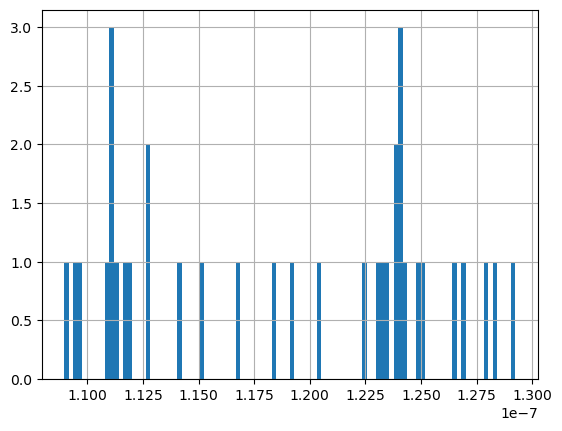

In [73]:
X2_y_pd.amihud_lambda.hist(bins=100)
amihud_lambda = X2_y_pd.amihud_lambda
amihud_lambda_mean = ta.MA(amihud_lambda,2)
amihud_lambda_std = ta.STDDEV(amihud_lambda,2)
amihud_lambda_norm = (amihud_lambda - amihud_lambda_mean) / amihud_lambda_std
# amihud_lambda_norm.hist(bins=100)
# amihud_lambda_norm.hist(bins = 100)
amihud_lambda_norm


<Axes: >

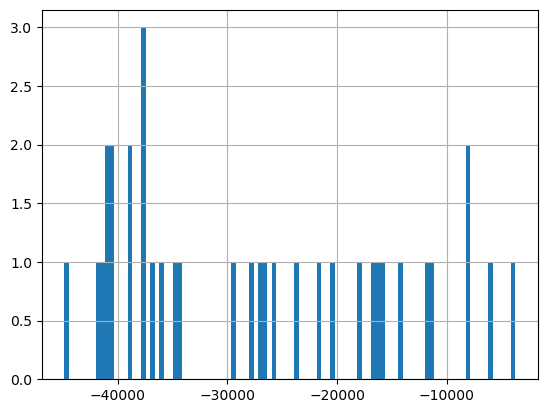

In [74]:
X2_y_pd.ofi_signed_qty_sum.hist(bins=100)
# X2_y_pd.ofi_signed_quote_sum.plot()
# X2_y_pd.ofi_trade_count_diff.plot()
# X2_y_pd.ofi_signed_quote_sum.hist(bins = 100)

window 3, ic 0.03209916616044588
window 6, ic 0.044239058249788916
window 9, ic 0.043831799016594286
window 12, ic 0.04294684012548155
window 15, ic 0.04491623932024987
window 18, ic 0.046151937840471245
window 21, ic 0.04523979586129549
window 24, ic 0.0380677267239767
window 27, ic 0.02619202330057348


<Axes: >

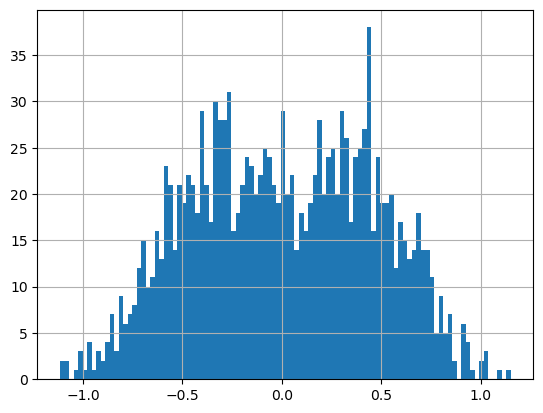

In [23]:
ofi_signed_qty_sum = X2_y_pd.ofi_signed_qty_sum
normal_window = range(3,30,3)

for window in normal_window:
    ofi_signed_qty_sum_mean = ta.MA(ofi_signed_qty_sum,window)
    ofi_signed_qty_sum_std = ta.STDDEV(ofi_signed_qty_sum,window)
    ofi_signed_qty_sum_norm = (ofi_signed_qty_sum - ofi_signed_qty_sum_mean) / ofi_signed_qty_sum_std / 3
    print('window {}, ic {}'.format(window, ofi_signed_qty_sum_norm.corr(X2_y_pd.close)))

ofi_signed_qty_sum_norm.hist(bins=100)
# ofi_trade_count_diff_mean = ta.MA(ofi_trade_count_diff,5)
# ofi_trade_count_diff_std = ta.STDDEV(ofi_trade_count_diff,5)
# ofi_trade_count_diff_norm = (ofi_trade_count_diff - ofi_trade_count_diff_mean) / ofi_trade_count_diff_std
# # ofi_trade_count_diff_norm.plot()
# ofi_trade_count_diff_norm.hist(bins=100)
# ofi_trade_count_diff_norm.corr(X2_y_pd.close)

# X2_y_pd['ofi_trade_count_diff_norm'].corr(X2_y_pd.close)

<Axes: >

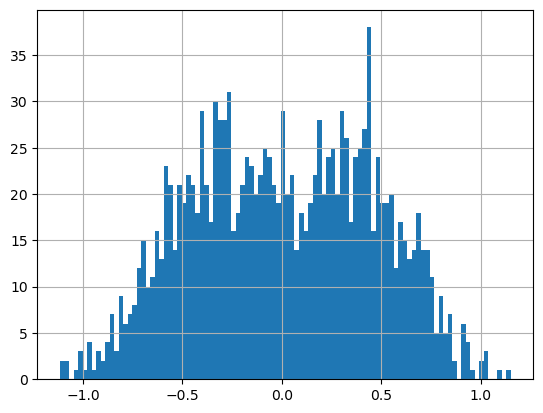

In [27]:
ofi_signed_qty_sum_norm.hist(bins=100)

In [28]:
# ofi_signed_qty_sum_norm_position = ofi_signed_qty_sum_norm
high_freq_downside_ratio_norm_position_binning_position = ((ofi_signed_qty_sum_norm>0.5)|(ofi_signed_qty_sum_norm<-0.5)) * ofi_signed_qty_sum_norm
high_freq_downside_ratio_norm_position_binning_position

end_time
2025-01-01 11:18:44.204    NaN
2025-01-01 11:41:38.844    NaN
2025-01-01 11:53:35.686    NaN
2025-01-01 12:22:17.185    NaN
2025-01-01 12:35:28.996    NaN
                          ... 
2025-01-10 19:58:10.127   -0.0
2025-01-10 20:16:19.370   -0.0
2025-01-10 20:32:00.070   -0.0
2025-01-10 20:44:19.155   -0.0
2025-01-10 20:59:55.156   -0.0
Length: 1477, dtype: float64

In [29]:

net_value = 1+(high_freq_downside_ratio_norm_position_binning_position*X2_y_pd['close'].fillna(0)).cumsum()

<Axes: xlabel='end_time'>

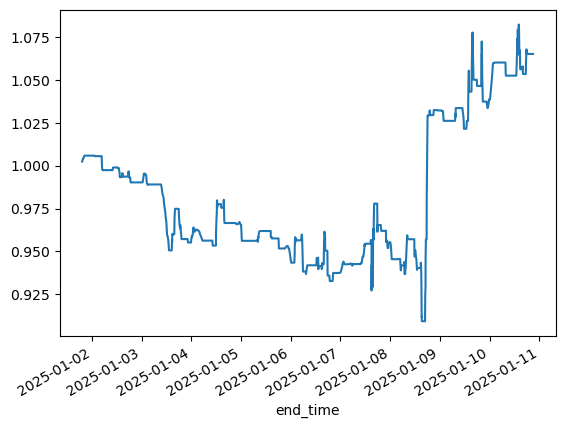

In [31]:
net_value.plot()